In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import sys
%matplotlib inline

### Library info:


In [22]:
print("Python = ",sys.version.split("|")[0])
print("Tensorflow = ", tf.__version__)
print("Numpy = ",np.version.version)

Python =  3.5.2 
Tensorflow =  0.12.0-rc0
Numpy =  1.11.3


### Loading data

In [23]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [24]:
print("length of training set :\t\t{}".format(len(data.train.labels)))
print("length of test set :\t\t{}".format(len(data.test.labels)))
print("length of validation set :\t\t{}".format(len(data.validation.labels)))

length of training set :		55000
length of test set :		10000
length of validation set :		5000


In [25]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [26]:
data.test.cls[4:9]

array([4, 1, 4, 9, 5])

In [27]:
len(data.train.images[0])

784

In [28]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [29]:
# to plot images 
def plotDigits(digits, actualDigit, predDigit=None):
    
    # create a plot matrix for the digits
    noDigits = len(digits)
    row = int(math.sqrt(noDigits))
    col = math.ceil(noDigits/row)
    
    fig, axes = plt.subplots(row, col)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        if i<noDigits:
            # Plot digit image.
            ax.imshow(digits[i].reshape(img_shape), cmap='binary')
            
            # Show actual and predicted classes.
            if predDigit is None:
                xlabel = "Actual: {0}".format(actualDigit[i])
            else:
                xlabel = "Actual: {0}, Pred: {1}".format(actualDigit[i], predDigit[i])

            ax.set_xlabel(xlabel)
             
        ax.set_xticks([])
        ax.set_yticks([])

### plotting some test images

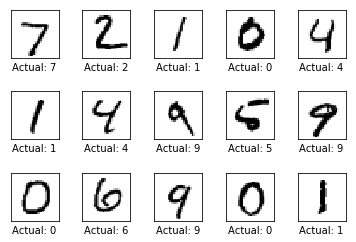

In [30]:
# Get the first images from the test-set.
digits = data.test.images[0:15]

# Get the true classes for those images.
actualDigits = data.test.cls[0:15]

# Plot the images and labels using our helper-function above.
plotDigits(digits=digits, actualDigit=actualDigits)

# <span style="color:orange"> TensorFlow Graph</span>
The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.  
TensorFlow can also **automatically calculate the gradients** that are needed to optimize the variables of the graph so as to make the model perform better.   
This is because the **graph is a combination of simple mathematical expressions** so the gradient of the entire graph can be calculated using the **chain-rule for derivatives**.

A TensorFlow graph consists of the following parts which will be detailed below:
* **Placeholder variables** used to change the input to the graph.
* **Model variables** that are going to be optimized so as to make the model perform better.
* **The model** which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A **cost measure** that can be used to guide the optimization of the variables.
* An **optimization method** which updates the variables of the model.  



## <span style="color:green">1. Placeholder variables</span>

Placeholder variables = **input to the graph**
* **change each time we execute the graph**. 

In this we create 3 placeholder variables:

* placeholder variable for the <span style="color:blue">**input images**.</span>   
    * data-type = float32
    * shape is set to [None, img_size_flat]
        * None means that the tensor may hold an __arbitrary number of images__ 
        * each image being a vector of length img_size_flat.


In [31]:
x = tf.placeholder(tf.float32,[None,img_size_flat])

* placeholder variable for the <span style="color:blue">**true labels** associated with the images</span>
    * shape = [None, num_classes] 

In [32]:
y_true = tf.placeholder(tf.float32,[None,num_classes])

* placeholder variable for the <span style="color:blue">**true class** of each image</span>
    * dtype = int64 
    * shape = [None] 
        * means the placeholder variable is a one-dimensional vector of arbitrary length.

In [33]:
y_true_cls = tf.placeholder(tf.int64,[None])

## <span style="color:green">2. Model Variables to be optimized</span>
* These are the variables that define the model 
* These would be changed when the optimization is done 
* We have 2 variables in this example
<div style="color:blue">
    1. Weights   
    2. Biases
</div>
* we use truncated_normal to randomize initial weights and biases

In [34]:
weights = tf.Variable(tf.truncated_normal([img_size_flat,num_classes],stddev=0.001))
biases = tf.Variable(tf.truncated_normal([num_classes],stddev=0.001))

## <span style="color:green">3. Model</span>
* for test purpose we use a simple mathematical model 
    * multiplies the images in the placeholder variable x with the weights and then adds the biases.  
* The result is a matrix of shape [num_images, num_classes] 
    * x has shape [num_images, img_size_flat] 
    * weights has shape [img_size_flat, num_classes], 
    * multiplication of those two matrices is a matrix with shape [num_images, num_classes] 
    * biases vector is added to each row of that matrix.  



In [35]:
logits = tf.matmul(x,weights)+biases

* logits is a matrix
    * rows = num_images
    * cols = num_classes   
* logits[i,j] =  **likelihood** that the $i$'th input image is to be of the $j$'th class  

* we then normalize them using **softmax** function
    * each row of the logits matrix sums to one
    * each element is limited between [0,1]  
    
  
* store it in **y_pred**


In [36]:
y_pred = tf.nn.softmax(logits)

* The predicted class  = column with the max probability  


* stored in **y_pred_cls**



In [37]:
y_pred_cls = tf.arg_max(y_pred,dimension=1)

## <span style="color:green">4. Cost-function to be optimized</span>

comparing the predicted output of the model y_pred to the desired output y_true.  

* The cross-entropy is a performance measure used in classification. 
    * The cross-entropy is a continuous function that is always positive 
    * if the predicted output = actual output ==> cross-entropy equals zero.     
      
      
* The goal of optimization = **minimize cross-entropy** by changing the weights and biases


In [38]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)


* calculated the cross-entropy for each of the image classifications 
    * we have a measure of how well the model performs on **each image individually**
* But in order to use the cross-entropy to guide the optimization of the model's variables 
    * we need a single scalar value
    * so we simply take the average of the cross-entropy for all the image classifications.
      
* store it in **cost**

In [39]:
cost = tf.reduce_mean(cross_entropy)

## <span style="color:green">5. Optimization method</span>

* we have a cost measure that must be minimized
    * create an optimizer

* In this example it is a simple Gradient Descent where the step-size is set to 0.5.  



In [40]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

## Performance measures
### <span style="color:green">Accuracy  </span>



In [41]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls) # gives an array of True and False values

# convert False =0, True =1 
# calculate mean i.e. Total True/ total Values
# this gives accuracy

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

# <span style = "color:green">Tensorflow graph created</span>

# <span style = "color:red"> Tensorflow run</span>

### Creating tensorflow session

In [42]:
#session.close()

In [43]:
session = tf.Session()

### Initialize variables
The variables for weights and biases must be initialized before we start optimizing them.

In [45]:
session.run(tf.global_variables_initializer())

In [46]:
def checkWeights():
    w = session.run(weights)
    print(np.min(w),np.max(w))

In [47]:
checkWeights()

-0.00199937 0.00199985


### Helper-function to perform optimization iterations
taking mini batches of 100 instead of all 50,000 images

In [48]:
batch_size = 100

Function for performing a number of optimization iterations so as to gradually improve the weights and biases of the model.  
In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples


In [49]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
    

### Helper-functions to show performance
Dict with the test-set data to be used as input to the TensorFlow graph.   
Note that we must use the correct names for the placeholder variables in the TensorFlow graph

In [50]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

Function for printing the classification accuracy on the test-set.

In [52]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

Printing confusion matrix

In [53]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

Function for plotting examples of images from the test-set that have been mis-classified.

In [54]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    # correct is a numpy array?
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plotDigits(digits=images[0:9],
                actualDigit = cls_true[0:9],
                predDigit =cls_pred[0:9])

#### Helper-function to plot the model weights
Function for plotting the weights of the model. 10 images are plotted, one for each digit that the model is trained to recognize.

In [55]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    print(w_min, w_max)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization


In [56]:
print_accuracy()

Accuracy on test-set: 9.7%


-0.00199937 0.00199985


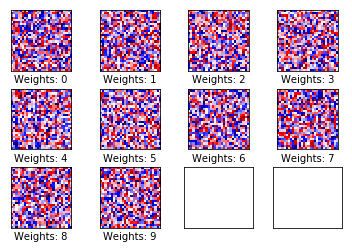

In [57]:
plot_weights()

[[  0  95 177  78 164  22  59 336   4  45]
 [  0  14  31  19  59   1  10 863 137   1]
 [  1 292  48  43  60  25  16 458  78  11]
 [  5 101  32 141 171  24  46 226 138 126]
 [ 14  35 102  16   2   5  21 381 353  53]
 [  2  21 118  62  60  40  53 319  48 169]
 [ 11  97  70  14  13  61  87 408 104  93]
 [  3  26  64  64  21 101  36 447 212  54]
 [  0  26  78  27   7  25  97 499 111 104]
 [  6  10  29  15   3  33  66 601 166  80]]


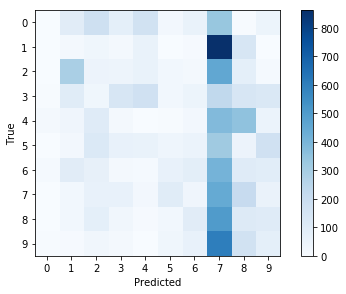

In [58]:
print_confusion_matrix()

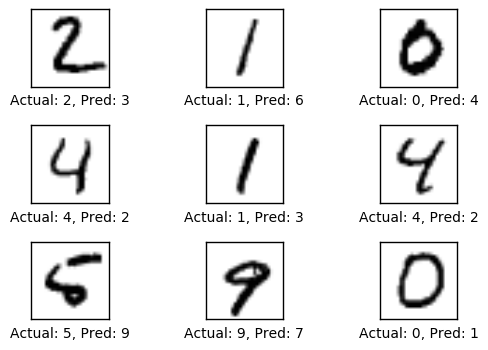

In [97]:
plot_example_errors()

### running the optimizer once

In [59]:
%timeit optimize(num_iterations=1)
print_accuracy()


The slowest run took 167.51 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.57 ms per loop
Accuracy on test-set: 50.2%


-0.115406 0.0984275


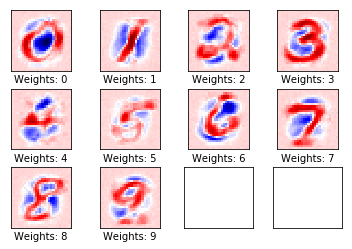

In [60]:
plot_weights()

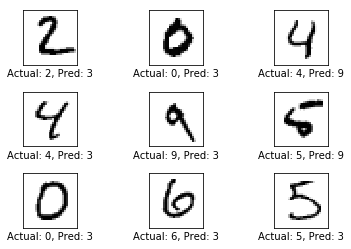

In [61]:
plot_example_errors()

### running optimizer for 10 instances
already ran for 1, so will run for 9 more

In [62]:
%timeit optimize(num_iterations=9)
print_accuracy()

10 loops, best of 3: 26.5 ms per loop
Accuracy on test-set: 88.3%


-0.532979 0.580618


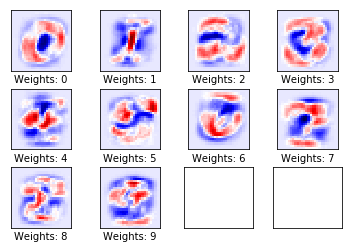

In [63]:
plot_weights()

[[ 966    0    0    4    1    2    5    1    1    0]
 [   0 1111    0    7    1    3    4    1    8    0]
 [  17   12  850   56   25    1   11   20   37    3]
 [   2    0    6  960    3   18    2    8    7    4]
 [   2    4    2    2  955    1    5    1    3    7]
 [  12    3    2   93   26  704   19   10   17    6]
 [  18    3    3    5   45    9  875    0    0    0]
 [   4   17   16   14   16    0    1  947    0   13]
 [  12   14    5   85   34   46   15   19  744    0]
 [  21    8    2   21  180    7    0   48    3  719]]


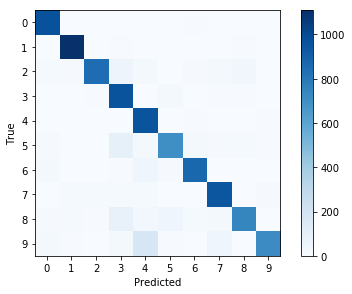

In [64]:
print_confusion_matrix()

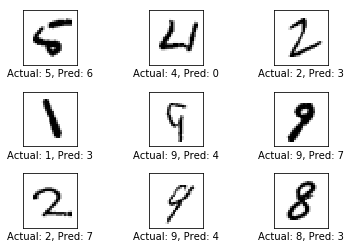

In [65]:
plot_example_errors()

### running optimizer for 100 reps

In [66]:
%timeit optimize(num_iterations=90)
print_accuracy()

1 loop, best of 3: 263 ms per loop
Accuracy on test-set: 91.1%


-0.627968 0.661957


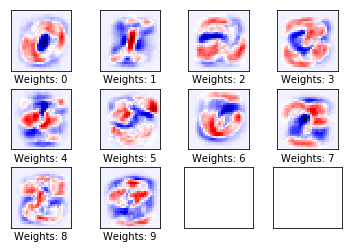

In [67]:
plot_weights()

[[ 967    0    0    3    0    3    5    1    1    0]
 [   0 1101    0   12    0    2    4    2   14    0]
 [  13    6  864   52   10    1   15   19   44    8]
 [   4    0    6  964    0   12    1    8   11    4]
 [   2    1    2    3  891    0   16    3   11   53]
 [  13    2    0   79    9  719   18    7   38    7]
 [  17    3    3    3    8    9  912    2    1    0]
 [   4    7   16   16    5    0    0  942    4   34]
 [  10    3    2   68    7   16   13   13  838    4]
 [  12    5    1   18   19    4    1   25    9  915]]


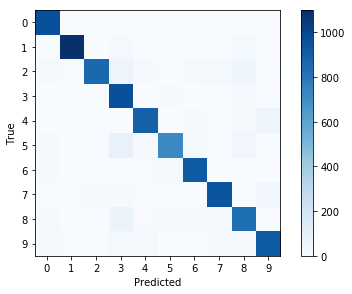

In [68]:
print_confusion_matrix()

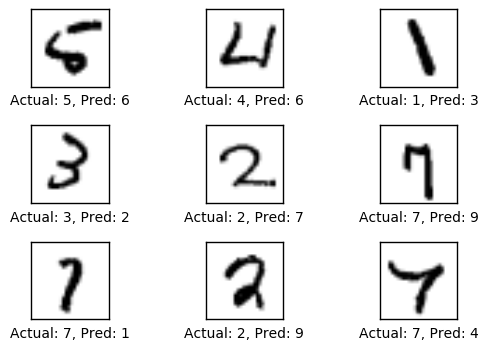

In [108]:
plot_example_errors()

### running optimizer fot 1000 loops

In [69]:
%timeit optimize(num_iterations=990)
print_accuracy()

1 loop, best of 3: 3.09 s per loop
Accuracy on test-set: 92.4%


-1.01155 1.37848


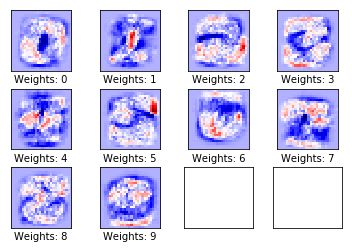

In [70]:
plot_weights()

[[ 964    0    1    1    0    4    6    3    1    0]
 [   0 1111    2    2    0    1    4    2   13    0]
 [   8   10  917    9    9    3   14   13   44    5]
 [   5    0   19  906    0   31    3   15   22    9]
 [   1    2    4    2  914    0   11    6    6   36]
 [  10    2    2   33   14  770   19    9   27    6]
 [  12    3    4    1    9   10  915    3    1    0]
 [   2    8   17    6    6    1    0  961    3   24]
 [   6    8    6   23    9   28   12   14  861    7]
 [  12    7    1    8   22    5    0   29    7  918]]


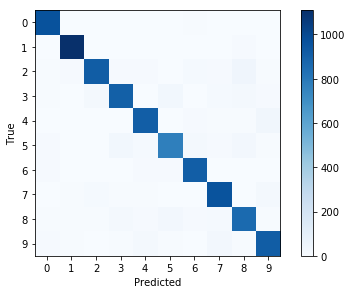

In [71]:
print_confusion_matrix()

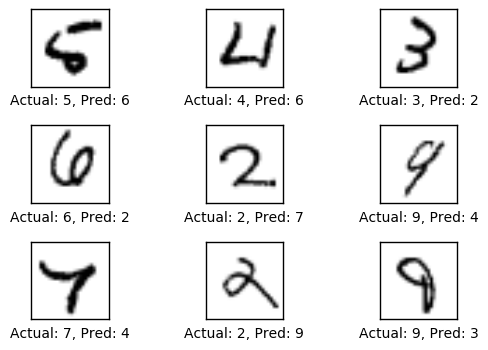

In [112]:
plot_example_errors()

### running optimizer for 5000 loops

In [72]:
%timeit optimize(num_iterations=4000)
print_accuracy()

1 loop, best of 3: 12.6 s per loop
Accuracy on test-set: 92.4%


-1.81177 2.2313


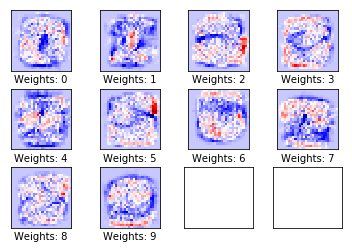

In [73]:
plot_weights()

[[ 952    0    2    3    0    6   12    3    1    1]
 [   0 1119    4    1    0    1    3    2    5    0]
 [   4   10  938   12    9    3   16    8   27    5]
 [   3    1   22  914    1   27    4   10   18   10]
 [   1    3    6    3  917    0   10    3    6   33]
 [   9    3    3   31   10  782   18    6   22    8]
 [   7    3    7    1    8   13  916    2    1    0]
 [   1   10   22    4    6    1    0  946    2   36]
 [   8   13   11   24    8   39   18    8  830   15]
 [   8    8    1   11   28    5    1   17    5  925]]


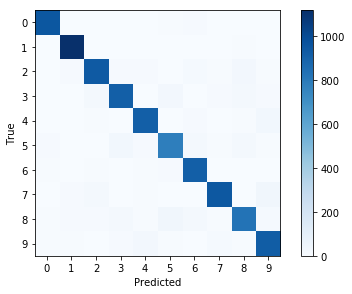

In [74]:
print_confusion_matrix()

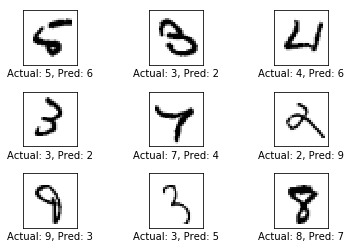

In [75]:
plot_example_errors()